



## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### Инструкция по выполнению проекта

1. Загрузите данные и выполните их ресемплирование по одному часу.
2. Проанализируйте данные.
3. Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
4. Проверьте данные на тестовой выборке и сделайте выводы.

### Описание данных

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце '*num_orders*' (от англ. *number of orders*, «число заказов»).

# 1. Подготовка

In [1]:
import pandas as pd

#Импорт и чтение  датасет 
data = pd.read_csv('/datasets/taxi.csv')

data.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [2]:
# Информация датасета
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
datetime      26496 non-null object
num_orders    26496 non-null int64
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [3]:
from IPython.display import FileLink, FileLinks

data.to_csv(r'data_numer_methods.csv', index=False)

In [4]:
#Проверка наличия NaN
data.isna().sum()

datetime      0
num_orders    0
dtype: int64

In [5]:
#Проверка наличия дубликатов 
data.duplicated().sum()

0

In [6]:
# Откритие датасет и размещение даты как индексы
df =  pd.read_csv('/datasets/taxi.csv', index_col = [0], parse_dates = [0])

#Проверка сортировки индексов
print(df.index.is_monotonic)


df.head()

True


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


# 2. Анализ

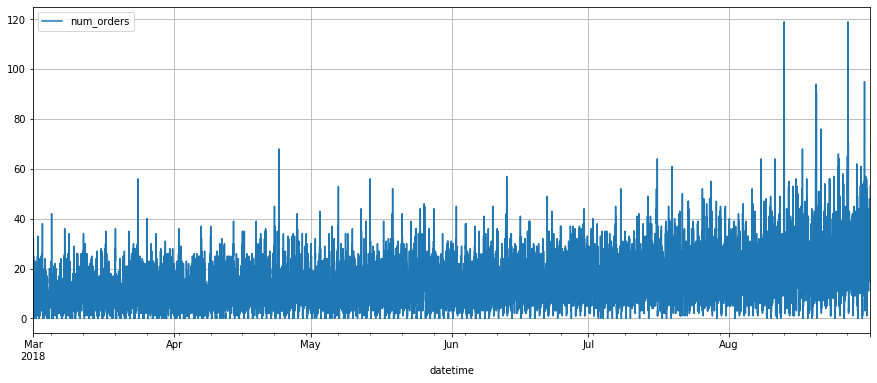

In [7]:
#График кол-во заказов по 10 минутам
df.plot(figsize = (15,6), grid = True)

### Вывод
Из графика сложно делать какие либо выводы. Далее развираем графики 

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose

#Ресамплирование по часам в датасете
df_h = df.resample('1H').sum()

#Декомпонируем ресамлирования датасета
df_dec= seasonal_decompose(df_h)

df_h.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [9]:
#Описание количество заказов по часам
df_h.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


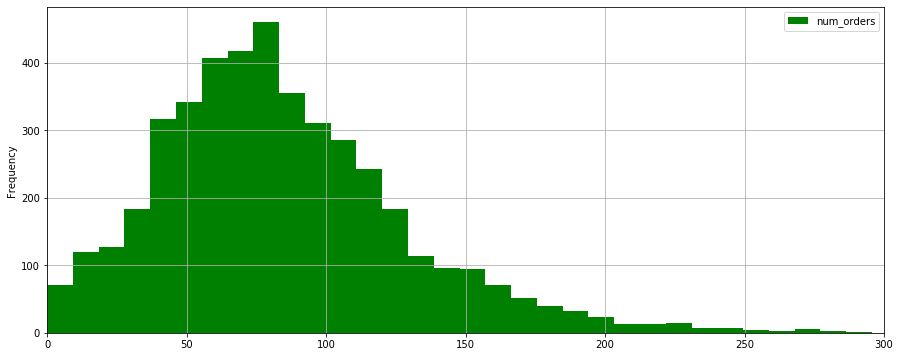

In [10]:
#Гистограм количество заказов по часам
df_h.plot(kind= 'hist', bins = 50, grid = True, figsize = (15,6), xlim = (0,300), color ='g')

### Вывод
Из графика гистограмы можно отметить что среднее количество заказов в час состовляет 85,и стандартное отклонение состовляет 45. То есть 99% значений попадает в диапазоне от 0 до 220 заказов.

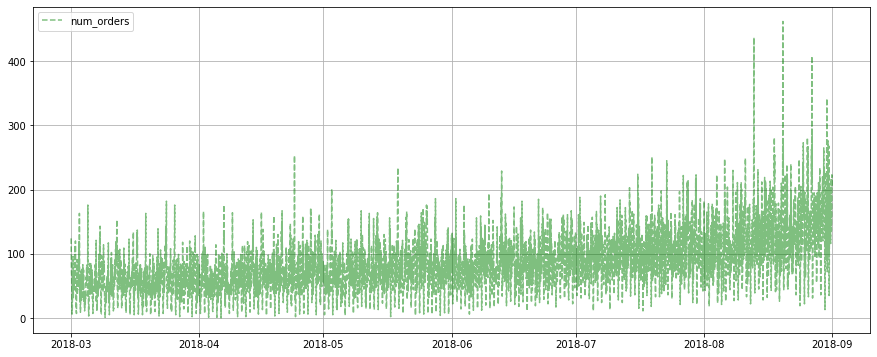

In [11]:
import matplotlib.pyplot as plt

plt.figure(1, figsize=(15, 6))
plt.plot(df_h['num_orders'], '--g', label='num_orders', alpha = 0.5)
plt.grid()
plt.legend()


(None, <matplotlib.legend.Legend at 0x7fd5463c9690>)

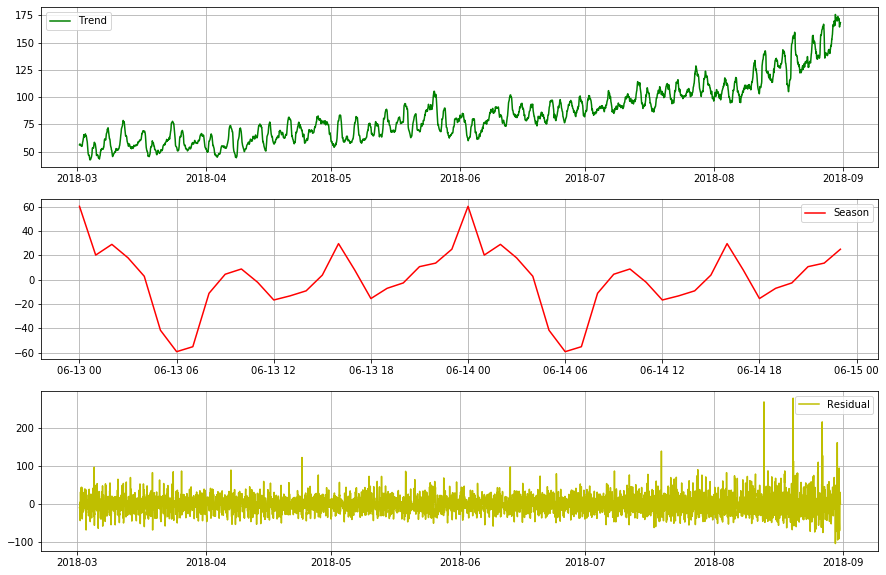

In [12]:
from matplotlib.dates import HourLocator 
fig , ax = plt.subplots(1,3, figsize=(15, 10))

plt.subplot(3,1,1)
plt.plot(df_dec.trend, color = 'g', label = 'Trend')
plt.legend(), plt.grid()


plt.subplot(3,1,2)
plt.plot(df_dec.seasonal['2018-06-13':'2018-06-14'] ,  label = 'Season', color = 'r')
plt.grid(), plt.legend()


plt.subplot(3,1,3)
plt.plot(df_dec.resid , label = 'Residual', color = 'y')
plt.grid(), plt.legend()



### Вывод
Из декомпозиции можно отметить, что тренд указывает на увеличение заказов. Сезоность указывает на высокий спрос на ночное время, то что вполне соответсвует динамика общетсвенного транспорта по скольку он не работает в ночное время.

# 3. Обучение

In [13]:
#Определение фунуция создание признаков
def make_features(data, max_lag, rolling_sum_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_sum_size).sum()

#Применняем функцию на датасет ресамплтрован по часам
make_features(df_h, 20,24)
df_h.shape

(4416, 26)

In [14]:
#Выведение датасет расамплтровам по часам
df_h.tail().T

datetime,2018-08-31 19:00:00,2018-08-31 20:00:00,2018-08-31 21:00:00,2018-08-31 22:00:00,2018-08-31 23:00:00
num_orders,136.0,154.0,159.0,223.0,205.0
year,2018.0,2018.0,2018.0,2018.0,2018.0
month,8.0,8.0,8.0,8.0,8.0
day,31.0,31.0,31.0,31.0,31.0
dayofweek,4.0,4.0,4.0,4.0,4.0
lag_1,207.0,136.0,154.0,159.0,223.0
lag_2,217.0,207.0,136.0,154.0,159.0
lag_3,197.0,217.0,207.0,136.0,154.0
lag_4,116.0,197.0,217.0,207.0,136.0
lag_5,133.0,116.0,197.0,217.0,207.0


In [15]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Разделение датасета на трайн и тест(10%от датасета)
train, test = train_test_split(df_h, shuffle=False, test_size=0.1)
train, valid = train_test_split(df_h, shuffle=False, test_size=0.1)
train = train.dropna()

features = train.drop('num_orders', axis = 1 )
target = train['num_orders']

valid_features = valid.drop('num_orders', axis =1)
valid_target = valid['num_orders']

test_features = test.drop('num_orders', axis = 1)
test_target = test['num_orders']
#Проверка размера датасета трайн и тест
print(train.shape , '\n',
      valid.shape, '\n',
test.shape)

(3950, 26) 
 (442, 26) 
 (442, 26)


In [16]:
%time
# подбор параметров для LinearRegressor  и вывод RMSE на тестовый датасет 

          
LR = LinearRegression()
LR.fit(features,target)
pred = LR.predict(valid_features)
rmse_lr = mean_squared_error(valid_target,pred)**0.5
rmse_lr



CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 7.39 µs


46.60386394747334

In [17]:
%time
from itertools import product
from sklearn.ensemble import RandomForestRegressor
# подбор параметров для RandomForestRegressor  и вывод RMSE на тестовый датасет 
buf_2 = dict()
for i in product([{'n_estimators':10},{'n_estimators':100}],
              [{'max_depth':10},{ 'max_depth':100}, {'max_depth':10}],
              [{'min_samples_split':0.5},{'min_samples_split':10},{'min_samples_split':100}]):
    rfr = RandomForestRegressor(random_state = 123,**i[0],**i[1],**i[2])
    rfr.fit(features,target)
    pred_2 = rfr.predict(valid_features)
    buf_2[str(i)] = mean_squared_error(valid_target,pred_2)**0.5

buf_2

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 7.15 µs


{"({'n_estimators': 10}, {'max_depth': 10}, {'min_samples_split': 0.5})": 73.64298996241861,
 "({'n_estimators': 10}, {'max_depth': 10}, {'min_samples_split': 10})": 52.81499849028727,
 "({'n_estimators': 10}, {'max_depth': 10}, {'min_samples_split': 100})": 57.34589317347528,
 "({'n_estimators': 10}, {'max_depth': 100}, {'min_samples_split': 0.5})": 73.64298996241861,
 "({'n_estimators': 10}, {'max_depth': 100}, {'min_samples_split': 10})": 52.439009964733216,
 "({'n_estimators': 10}, {'max_depth': 100}, {'min_samples_split': 100})": 57.37725995797455,
 "({'n_estimators': 100}, {'max_depth': 10}, {'min_samples_split': 0.5})": 73.7757349631965,
 "({'n_estimators': 100}, {'max_depth': 10}, {'min_samples_split': 10})": 53.26788686476514,
 "({'n_estimators': 100}, {'max_depth': 10}, {'min_samples_split': 100})": 57.380798271860506,
 "({'n_estimators': 100}, {'max_depth': 100}, {'min_samples_split': 0.5})": 73.7757349631965,
 "({'n_estimators': 100}, {'max_depth': 100}, {'min_samples_split

In [18]:
%time
from sklearn.tree import DecisionTreeRegressor
# подбор параметров для DecisionTreeRegressor  и вывод RMSE на тестовый датасет 
buf_3 = dict()
for i in product(
              [{'max_depth':10},{ 'max_depth':50}, {'max_depth':100}],
              [{'min_samples_split':2},{ 'min_samples_split':0.5}, {'min_samples_split':10}],
              [{'min_samples_split':0.5},{'min_samples_split':2}],
                ):
    dtr = DecisionTreeRegressor(random_state =123,**i[0],**i[1])
    dtr.fit(features,target)
    pred_3 = dtr.predict(valid_features)
    buf_3[str(i)] = mean_squared_error(valid_target,pred_3)**0.5

buf_3

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.15 µs


{"({'max_depth': 10}, {'min_samples_split': 2}, {'min_samples_split': 0.5})": 68.85644754596159,
 "({'max_depth': 10}, {'min_samples_split': 2}, {'min_samples_split': 2})": 68.85644754596159,
 "({'max_depth': 10}, {'min_samples_split': 0.5}, {'min_samples_split': 0.5})": 65.38006403092432,
 "({'max_depth': 10}, {'min_samples_split': 0.5}, {'min_samples_split': 2})": 65.38006403092432,
 "({'max_depth': 10}, {'min_samples_split': 10}, {'min_samples_split': 0.5})": 60.85674857904069,
 "({'max_depth': 10}, {'min_samples_split': 10}, {'min_samples_split': 2})": 60.85674857904069,
 "({'max_depth': 50}, {'min_samples_split': 2}, {'min_samples_split': 0.5})": 64.58012666587915,
 "({'max_depth': 50}, {'min_samples_split': 2}, {'min_samples_split': 2})": 64.58012666587915,
 "({'max_depth': 50}, {'min_samples_split': 0.5}, {'min_samples_split': 0.5})": 65.38006403092432,
 "({'max_depth': 50}, {'min_samples_split': 0.5}, {'min_samples_split': 2})": 65.38006403092432,
 "({'max_depth': 50}, {'min_sa

In [19]:
%%time
import lightgbm as lgb


# подбор параметров для LGBMRegressor  и вывод RMSE на тестовый датасет 

buf_lgb = dict()
for i in product([{'feature_fraction':0.1},{ 'feature_fraction':0.9}],
                 [{'bagging_fraction':0.1},{ 'bagging_fraction':0.9}],                 
              [{'num_leaves':10},{ 'num_leaves':50}, {'num_leaves':1000}],
              [{'n_estimators':2},{ 'n_estimators':50}, {'n_estimators':100}],
              [{'max_depth':10},{'max_depth':100}],
                ):
    model_lgb = lgb.LGBMRegressor(**i[0],**i[1],**i[2],**i[3],**i[4])
    model_lgb.fit(features,target)
    pred_lgb = model_lgb.predict(valid_features)
    buf_lgb[str(i)] = mean_squared_error(valid_target,pred_lgb)**0.5

buf_lgb

CPU times: user 1min 21s, sys: 1.29 s, total: 1min 22s
Wall time: 1min 23s


{"({'feature_fraction': 0.1}, {'bagging_fraction': 0.1}, {'num_leaves': 10}, {'n_estimators': 2}, {'max_depth': 10})": 82.95671431287266,
 "({'feature_fraction': 0.1}, {'bagging_fraction': 0.1}, {'num_leaves': 10}, {'n_estimators': 2}, {'max_depth': 100})": 82.95671431287266,
 "({'feature_fraction': 0.1}, {'bagging_fraction': 0.1}, {'num_leaves': 10}, {'n_estimators': 50}, {'max_depth': 10})": 62.913034887639455,
 "({'feature_fraction': 0.1}, {'bagging_fraction': 0.1}, {'num_leaves': 10}, {'n_estimators': 50}, {'max_depth': 100})": 62.913034887639455,
 "({'feature_fraction': 0.1}, {'bagging_fraction': 0.1}, {'num_leaves': 10}, {'n_estimators': 100}, {'max_depth': 10})": 58.047862580263704,
 "({'feature_fraction': 0.1}, {'bagging_fraction': 0.1}, {'num_leaves': 10}, {'n_estimators': 100}, {'max_depth': 100})": 58.047862580263704,
 "({'feature_fraction': 0.1}, {'bagging_fraction': 0.1}, {'num_leaves': 50}, {'n_estimators': 2}, {'max_depth': 10})": 82.80064336889077,
 "({'feature_fraction

In [20]:
# Поиск найлучше рузкльтата по RMSE для кажлой модели 
best_result = []
for buffer in ( buf_2, buf_3, buf_lgb):
    param = min(buffer.items(), key=lambda x: x[1]) 
    best_result.append(param)

best_result

[("({'n_estimators': 100}, {'max_depth': 100}, {'min_samples_split': 10})",
  52.328352994588194),
 ("({'max_depth': 10}, {'min_samples_split': 10}, {'min_samples_split': 0.5})",
  60.85674857904069),
 ("({'feature_fraction': 0.9}, {'bagging_fraction': 0.1}, {'num_leaves': 50}, {'n_estimators': 100}, {'max_depth': 100})",
  46.81930843792855)]

### Вывод

Из обученных моделей, лучше результат получен на LinearRegressor с параметрами  и состовляет 46,6 и модель Lightgbm . Тоже наблюдалось что при увеличении количество Лагов, метрика RMSE снижается. 

# 4. Тестирование

In [21]:
#Тестируем модель линеар регрешн на датасет тест
test_predict = LR.predict(test_features)
rmse_test  =  mean_squared_error(test_target, test_predict)**0.5

rmse_test

46.60386394747334

In [22]:
print(pd.DataFrame(test_predict))

              0
0    135.251764
1    111.918978
2     96.482533
3     99.574930
4    138.181547
..          ...
437  116.456314
438  163.892175
439  192.032595
440  149.430354
441  182.741883

[442 rows x 1 columns]


In [32]:
len(test_features)


442

In [33]:
import numpy as np
#Проверка модели на адвекадности с помошью среднего значения
pred_median = np.ones(test.shape[0])*train['num_orders'].mean()
rmse_by_mean = mean_squared_error(test_target, pred_median)**0.5
print("RMSE check by mean:", rmse_by_mean)

RMSE check by mean: 84.6499381993622


In [34]:
#Проверка модели на адвекадности с помошью предыдущего значения ряда
pred_previous = test['num_orders'].shift()
pred_previous.shape

(442,)

In [35]:
#Проверка модели на адвекадности с помошью предыдущего значения ряда
pred_previous.iloc[0] =target.iloc[-1]
rmse_by_previous = mean_squared_error(test_target, pred_previous)**0.5
print("RMSE check by previous:", rmse_by_previous )

RMSE check by previous: 58.856486242815066


In [36]:
#Найменьше значение RMSE из полученных
best_rmse =  min(best_result)
type(best_rmse[-1])

numpy.float64

In [37]:
#Вывод по поводу сравнения полученого результата с качеством полученым из среднего значения и предыдушего значения.
if  min(rmse_by_previous,rmse_by_mean) > rmse_test:
    print('Модель адвекатный')
else:
    print(('Модель адвекатный'))

Модель адвекатный


 ### Вывод
 
После проверки качество, можно увидеть что минимальное значение  LinearRegressor с параметрами  и состовляет 46,6, что меньше в 26% чем 58,85.